In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

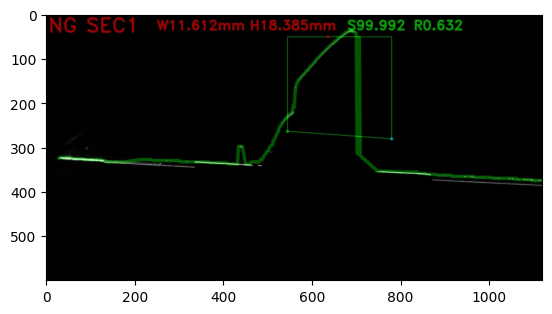

In [ ]:
img = cv2.imread(r"../251017~251223\251018\JG\0123_ABCDEF\Result\0009_NG_1_17141728_NG.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

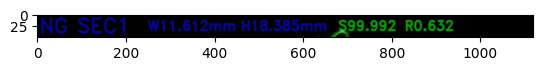

In [27]:
roi = img[:50, :]  # Example coordinates for ROI
plt.imshow(roi)

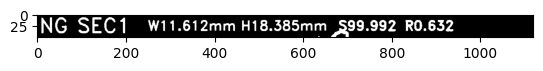

In [28]:
gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
_, binary = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY)
# filter
binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))
# show image
plt.imshow(binary, cmap='gray')

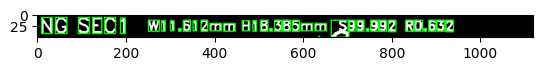

In [29]:
contours = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
# draw bounding boxes
contour_boxes = cv2.cvtColor(binary.copy(), cv2.COLOR_GRAY2BGR)
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(contour_boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)
plt.imshow(contour_boxes)


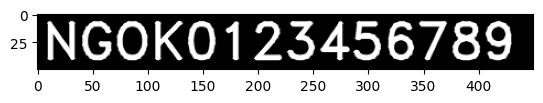

In [30]:
empty = np.zeros_like(roi)[:,:450]
cv2.putText(empty, "NGOK0123456789", (5, 40), cv2.FONT_HERSHEY_DUPLEX, 1.5, (255, 255, 255), 2, cv2.LINE_AA)
plt.imshow(empty)

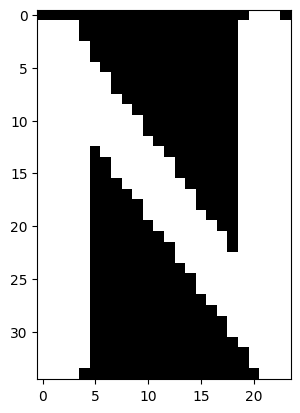

In [31]:
def render_glyph(ch, scale, thickness):
    (w, h), baseline = cv2.getTextSize(
        ch, cv2.FONT_HERSHEY_DUPLEX, scale, thickness
    )

    pad = 3
    img = np.zeros((h + baseline + pad*2, w + pad*2), dtype=np.uint8)

    cv2.putText(
        img, ch, (pad, h + pad),
        cv2.FONT_HERSHEY_DUPLEX, scale, 255, thickness, cv2.LINE_AA
    )

    _, img = cv2.threshold(
        img, 20, 255,
        cv2.THRESH_BINARY | cv2.THRESH_OTSU
    )
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))

    # crop to content
    ys, xs = np.where(img > 0)
    img = img[ys.min():ys.max()+1, xs.min():xs.max()+1]

    return img

templates = {
    'large': {ch: render_glyph(ch, 1.5, 2) for ch in "NGOKSEC0123456789"},
    'small': {ch: render_glyph(ch, 1.0, 2) for ch in "WHSRmm0123456789."},
}

# render one glyph example
plt.imshow(templates['large']['N'], cmap='gray')

In [32]:
# template matching
# sort contours left to right
contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[0])
matches = []
last_x = 0
for i, contour in enumerate(contours):
    x, y, w, h = cv2.boundingRect(contour)
    glyph_img = binary[y:y+h, x:x+w]

    if x - last_x > 10:
        matches.append((' ', 1.0))
    last_x = x+w

    best_ch = None
    best_score = -1

    # choose template size based on glyph height
    size_key = 'large' if h > 30 else 'small'
    for ch, tmpl in templates[size_key].items():
        if abs(tmpl.shape[0] - h) > 2 or abs(tmpl.shape[1] - w) > 2:
            continue
        # resize template to glyph height
        scale = h / tmpl.shape[0]
        tmpl_resized = cv2.resize(
            tmpl, (int(tmpl.shape[1] * scale), h),
            interpolation=cv2.INTER_NEAREST
        )

        # skip if widths differ too much
        if abs(tmpl_resized.shape[1] - w) > 10:
            continue

        # match template
        res = cv2.matchTemplate(
            glyph_img, tmpl_resized,
            cv2.TM_CCOEFF_NORMED
        )
        _, score, _, _ = cv2.minMaxLoc(res)

        if score > best_score:
            best_score = score
            best_ch = ch

    print(f"Glyph {i}: recognized as '{size_key} {best_ch}' with score {best_score:.3f}")
    matches.append((best_ch, best_score))

print("Recognized string:", ''.join(ch for ch, score in matches))


Glyph 0: recognized as 'large N' with score 0.981
Glyph 1: recognized as 'large G' with score 0.965
Glyph 2: recognized as 'large S' with score 0.975
Glyph 3: recognized as 'large E' with score 0.986
Glyph 4: recognized as 'large C' with score 0.914
Glyph 5: recognized as 'large 1' with score 0.995
Glyph 6: recognized as 'small W' with score 0.913
Glyph 7: recognized as 'small 1' with score 1.000
Glyph 8: recognized as 'small 1' with score 0.962
Glyph 9: recognized as 'small .' with score 1.000
Glyph 10: recognized as 'small 6' with score 0.951
Glyph 11: recognized as 'small 1' with score 1.000
Glyph 12: recognized as 'small 2' with score 0.945
Glyph 13: recognized as 'small m' with score 0.847
Glyph 14: recognized as 'small m' with score 0.959
Glyph 15: recognized as 'small H' with score 0.855
Glyph 16: recognized as 'small 1' with score 0.967
Glyph 17: recognized as 'small 8' with score 0.967
Glyph 18: recognized as 'small .' with score 1.000
Glyph 19: recognized as 'small 3' with sc

TypeError: sequence item 29: expected str instance, NoneType found